<a href="https://colab.research.google.com/github/dkssud8150/dacon-egovision/blob/main/egovision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 데이터 보기
import pandas as pd
import numpy as np
from glob import glob

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.utils.data import Dataset, ConcatDataset, Sampler, RandomSampler, BatchSampler

# 이미지데이터 로딩
from PIL import Image
import cv2
from tqdm import tqdm

# 파일경로 설정
import os
import shutil
import json
import PIL

# GPU 환경 설정
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

# warning
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')
import matplotlib.pyplot as plt

cuda:0


# Sample data

In [ ]:
data_path = '/content/drive/MyDrive/dacon'


train_path = data_path + '/train'
test_path = data_path + '/test'
retrain_path = data_path + '/retrain'

hand_gesture = pd.read_csv(data_path + '/hand_gesture_pose.csv')
sample_submission = pd.read_csv(data_path + '/sample_submission.csv')

### train 폴더 데이터 확인

In [ ]:
train_folders = sorted(glob(train_path + '/*'), key = lambda x : int(x.split('/')[-1]))
test_folders  = sorted(glob(test_path + '/*'), key = lambda x : int(x.split('/')[-1]))
train_folders[:5]

['/content/drive/MyDrive/dacon/train/0',
 '/content/drive/MyDrive/dacon/train/1',
 '/content/drive/MyDrive/dacon/train/2',
 '/content/drive/MyDrive/dacon/train/3',
 '/content/drive/MyDrive/dacon/train/4']

### 1개를 열어 확인

In [ ]:
train_folder1 = train_folders[620]
train_folder1

'/content/drive/MyDrive/dacon/train/620'

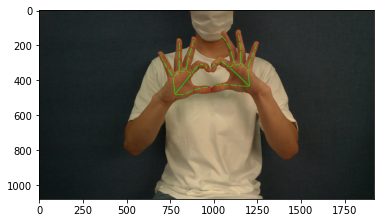

In [ ]:
image_paths = sorted(glob(train_folder1 + '/*.png'), key = lambda x : int(x.split('/')[-1].replace('.png','')))
image_path = image_paths[0]

img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

### 메타데이터 정보 확인

* action(행동 정보) 
  * 손동작 label
  * 손동작 한글 이름
* actor(배우 정보)
  * 성별
  * 나이
  * 키
* id(파일 경로)
* annotations (주석 정보)
  * image_id : 이미지 번호
  * data : 키포인트 정보

In [ ]:
json_path   = glob(train_folder1 + '/*.json')[0]
js = json.load(open(json_path))

print("json keys                : ",js.keys())
print("json action info         : ",js.get('action'))
print("json actor info          : ",js.get('actor'))
print("json id info             : ",js.get('id'))                             # train/id
print("json annotations keys    : ",js.get('annotations')[0].keys())
print("json annotations sample  : ",js.get('annotations')[0].get('image_id')) # train/id/image_id.png 
print("json annotations sample  : ",js.get('annotations')[0].get('data'))     # train/id/image_id.png 의 kep point

json keys                :  dict_keys(['action', 'actor', 'id', 'annotations'])
json action info         :  [186, '큰하트']
json actor info          :  None
json id info             :  620
json annotations keys    :  dict_keys(['image_id', 'data'])
json annotations sample  :  0
json annotations sample  :  [[778.8010025024414, 483.245530128479, 0.051133594242855906], [832.6738357543945, 483.5382342338562, -17.841750383377075], [885.1345825195312, 457.77312755584717, -38.91024827957153], [931.4473342895508, 445.48444747924805, -67.60226726531982], [970.7613372802734, 440.5976343154907, -106.07502222061157], [874.0076637268066, 362.117657661438, -42.74148344993591], [918.4812355041504, 309.1277861595154, -96.67551040649414], [948.4206390380859, 314.3676209449768, -135.9917449951172], [965.0771713256836, 335.799458026886, -156.66542530059814], [841.5545654296875, 346.7590606212616, -69.53418016433716], [858.2997894287109, 264.18798565864563, -109.51632499694824], [875.1610565185547, 212.79398

## answer loading

In [ ]:
answers = []
for train_folder in train_folders :
    json_path = glob(train_folder + '/*.json')[0]
    js = json.load(open(json_path))
    cat = js.get('action')[0]
    cat_name = js.get('action')[1]
    answers.append([train_folder.replace(data_path,''),cat, cat_name])

answers = pd.DataFrame(answers, columns = ['train_path','answer', 'answer_name'])
classes = pd.get_dummies(answers[['answer']], columns = ['answer']).to_numpy()
aswname = pd.get_dummies(answers[['answer_name']], columns = ['answer_name']).to_numpy()

answers
#classes.shape[1]
#answers['answer'].unique()

,train_path,answer,answer_name
0,/train/0,0,숫자 1
1,/train/1,0,숫자 1
2,/train/2,10,숫자 1
3,/train/3,10,숫자 1
4,/train/4,10,숫자 1
...,...,...,...
644,/train/644,194,빅토리
645,/train/645,195,부정(엄지손 아래로)
646,/train/646,195,부정(엄지손 아래로)
647,/train/647,195,부정(엄지손 아래로)


# preprocessing

In [ ]:
BATCH_SIZE = 32

image_transforms = { 
    'retrain': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)), # 랜덤 크기로 자른 후 잘라낸 이미지의 크기는 256x256로 조정
        transforms.RandomRotation(degrees=15),                    # 영상을 -15~15도 범위에서 랜덤 각도로 회전
        transforms.RandomHorizontalFlip(),                        # 50% 확률로 이미지를 수평으로 랜덤하게 뒤집는다.
        transforms.CenterCrop(size=224),                          # 중앙에서 224x224 이미지를 자른다.
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])               # 3채널 tensor을 취하며 각 채널의 입력 평균과 표준 편차로 각 채널을 정규화
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

#split train val 

image_datasets = {x: datasets.ImageFolder(os.path.join(data_path,x),                        # 이미지 데이터를 불러오는 것을 의미. ../data/hymenoptera_data 위치에 접근해 train 폴더와 val 폴더에 접근해 데이터를 불러온다. 
                                          image_transforms[x]) for x in ['retrain', 'test']}  # 기존 정의한 data_transforms의 학습 데이터셋에 이용되는 전처리 과정, 검증 데이터셋에 이용되는 전처리 과정을 각각 적용하는 것
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],                            # 불러온 이미지를 mini-batch 단위로 구분하기 위해 utils.data.dataloader 함수를 이용. 각각 적용하기 위해 dictionary 구조를 사용
                                              batch_size = BATCH_SIZE,                      # mini-batch를 구성하는 데이터 개수는 기존에 정의한 batch-size로 설정
                                              num_workers = 0,                              # num_workers = 0 은 처리하는 프로세싱에 관련된 내용이며 멀티 프로세싱으로 진행하지 않는 한 0으로 기본값을 이용. 
                                                                                            # 프로세스를 동시에 처리하는 개수만큼 num_workers를 지정
                                              shuffle = True) for x in ['retrain', 'test']}   # 데이터 순서를 섞는 의미로 shuffle = true 


# Modeling

In [ ]:
''' 6. 불러온 특정 모델에 대하여 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
          print("\ntrain epoch: {} [{}/{}({:.0f}%]\tTrain Loss: {:.6f}".format(epoch,batch_idx * len(image),len(train_loader.dataset),100.*batch_idx / len(train_loader),loss.item()))

def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():                                                                   # 평가에서는 gradient를 통해 파라미터 값이 업데이트되는 현상을 방지하기 위해 no.grad 메서드를 이용해 gradient의 흐름을 억제
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [ ]:
''' 8. PyTorch 내에서 제공하는 미리 학습되지 않은 ResNet18 모델 불러온 후 Output 크기 설정하기 '''
import torchvision.models as models
model = models.resnet18(pretrained = False).to(DEVICE)                                      # false는 모델의 구조만 불러오고 initailzer에서 랜덤으로 샘플링한 값을 이용해 모델
                                                                                            
num_ftrs = model.fc.in_features                                                             # model를 이용해 불러온 resnet34 모델에 대해 fully connected layer을 구성하고 있는 부분에 접근한다. in_features는 input에 해당하는 노드수를 지정
model.fc = nn.Linear(num_ftrs, 157) # 157(classes.shape[1]), 217(answer row), 649(classes.shape[0])
model = model.to(DEVICE)

''' 9. Optimizer, Objective Function 설정하기 '''
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)                               
criterion = nn.CrossEntropyLoss()                           

In [ ]:
print(model.in_features)

In [ ]:
for epoch in tqdm(range(10)):                                                             # 학습을 진행할 때는 전체 데이터셋을 이용하는 횟수만큼 반복문을 실행
  train(model, dataloaders['retrain'], optimizer, log_interval=200)                       # 정의한 train함수 실행. model은 기존에 정의한 모델, train_loader은 학습 데이터, optimizer은 adam, log_interval은 mini-batch의 index를 이용해 과정을 출력

# Test function

In [ ]:
predictions = []
answers = []

with torch.no_grad():
  for test_folder in tqdm(test_folders):
    with open(test_folder + '/{}.json'.format(test_folder.split('/')[-1]), 'r') as js:
      temp = json.load(js)
      imgs = []
      for i in temp['annotations']:
        image_path = test_folder + '/{}.png'.format(i['image_id'])
        img = PIL.Image.open(image_path).convert('RGB')
        img = image_transforms['test'](img)
        imgs.append(img)

      imgs = torch.stack(imgs).to(DEVICE)
      
      prediction = model(imgs)
      prediction = torch.nn.Softmax(dim=1)(prediction)
      prediction = torch.mean(prediction, dim=0)
      
      predictions.append(prediction.cpu().numpy())

print("\n",len(predictions),len(predictions[0]))

# sample submission

In [ ]:
sample_submission.iloc[:,1:] = predictions
display(sample_submission.head())
sample_submission.to_csv('./submission.csv', index=False)

,Image_Path,Label_0,Label_1,Label_2,Label_3,Label_4,Label_5,Label_6,Label_7,Label_8,Label_9,Label_10,Label_11,Label_12,Label_13,Label_14,Label_15,Label_16,Label_17,Label_18,Label_19,Label_22,Label_23,Label_25,Label_26,Label_27,Label_28,Label_29,Label_31,Label_32,Label_34,Label_35,Label_36,Label_37,Label_39,Label_40,Label_41,Label_42,Label_43,Label_44,...,Label_142,Label_143,Label_144,Label_145,Label_146,Label_147,Label_148,Label_149,Label_150,Label_151,Label_153,Label_154,Label_155,Label_156,Label_157,Label_158,Label_159,Label_160,Label_161,Label_162,Label_163,Label_165,Label_167,Label_168,Label_169,Label_171,Label_172,Label_173,Label_174,Label_175,Label_177,Label_186,Label_188,Label_189,Label_190,Label_191,Label_192,Label_193,Label_194,Label_195
0,./test\649,0.009395,0.007558,0.008259,0.005699,0.008128,0.011552,0.005111,0.004351,0.004073,0.006696,0.008275,0.009446,0.002983,0.008663,0.006179,0.003904,0.007657,0.005157,0.005138,0.002488,0.007380,0.003872,0.002851,0.005278,0.012294,0.010584,0.005355,0.008809,0.002843,0.004081,0.006394,0.004864,0.004350,0.002795,0.002623,0.008124,0.009250,0.010609,0.006102,...,0.003195,0.005448,0.004772,0.009322,0.004290,0.004296,0.003567,0.004550,0.011385,0.006055,0.004453,0.005133,0.009172,0.006895,0.007758,0.004392,0.009994,0.006576,0.003458,0.008553,0.008244,0.003474,0.010709,0.014482,0.007295,0.006263,0.009946,0.006603,0.010261,0.004035,0.003716,0.004413,0.004550,0.005000,0.004726,0.003018,0.005029,0.004541,0.004331,0.005185
1,./test\650,0.009383,0.007577,0.007853,0.005696,0.008347,0.011630,0.005060,0.004373,0.004116,0.006767,0.007881,0.009563,0.003081,0.009044,0.006069,0.003761,0.007919,0.005105,0.005124,0.002491,0.007431,0.003808,0.002734,0.005392,0.011606,0.010241,0.005397,0.008777,0.002880,0.003960,0.006357,0.004876,0.004109,0.002792,0.002571,0.008151,0.009197,0.010654,0.006280,...,0.003278,0.005364,0.004842,0.009578,0.004385,0.004341,0.003585,0.004407,0.011704,0.006316,0.004465,0.005176,0.009021,0.007090,0.008082,0.004308,0.009624,0.006276,0.003433,0.008767,0.007784,0.003320,0.010892,0.014664,0.007259,0.006170,0.009965,0.006869,0.009989,0.004134,0.003722,0.004445,0.004431,0.004979,0.004692,0.003043,0.004995,0.004536,0.004284,0.005336
2,./test\651,0.009521,0.007297,0.008021,0.005727,0.008025,0.011789,0.005086,0.004343,0.004036,0.006791,0.008057,0.009754,0.003003,0.009029,0.006180,0.003710,0.007846,0.005124,0.005043,0.002425,0.007502,0.003779,0.002777,0.005285,0.012145,0.010298,0.005377,0.008972,0.002825,0.003965,0.006322,0.004790,0.004328,0.002845,0.002675,0.008327,0.009200,0.010999,0.005941,...,0.003276,0.005423,0.004743,0.009463,0.004240,0.004421,0.003528,0.004423,0.011620,0.006099,0.004430,0.005046,0.009128,0.007193,0.008111,0.004322,0.009856,0.006385,0.003404,0.008435,0.008028,0.003429,0.010968,0.014708,0.007277,0.006211,0.010059,0.006937,0.010051,0.004138,0.003735,0.004333,0.004449,0.004966,0.004762,0.003014,0.004808,0.004503,0.004315,0.005134
3,./test\652,0.009422,0.007603,0.008262,0.005798,0.008561,0.012067,0.005086,0.004417,0.003918,0.006853,0.008095,0.009417,0.003016,0.008847,0.006061,0.003750,0.007656,0.004991,0.005150,0.002464,0.007516,0.003697,0.002671,0.005471,0.011899,0.010645,0.005349,0.008929,0.002847,0.003993,0.006319,0.004703,0.004151,0.002923,0.002597,0.008312,0.009167,0.011084,0.006175,...,0.003350,0.005243,0.004829,0.009477,0.004321,0.004183,0.003380,0.004370,0.011460,0.006272,0.004292,0.004979,0.008991,0.007061,0.008098,0.004197,0.009939,0.006449,0.003444,0.008285,0.007770,0.003385,0.010724,0.014794,0.007265,0.006216,0.009986,0.006760,0.009922,0.004201,0.003853,0.004437,0.004267,0.005008,0.004681,0.003038,0.004830,0.004614,0.004363,0.005245
4,./test\653,0.009521,0.007582,0.008219,0.005705,0.008354,0.011757,0.005101,0.004225,0.003893,0.006974,0.008242,0.009378,0.003012,0.008851,0.006039,0.003713,0.007679,0.004946,0.005184,0.002471,0.007575,0.003835,0.002701,0.005462,0.012186,0.010700,0.005259,0.009044,0.002882,0.003983,0.006225,0.004640,0.004041,0.002814,0.002614,0.0

#  

#  

#  

#  

#  

#  

#  

#  